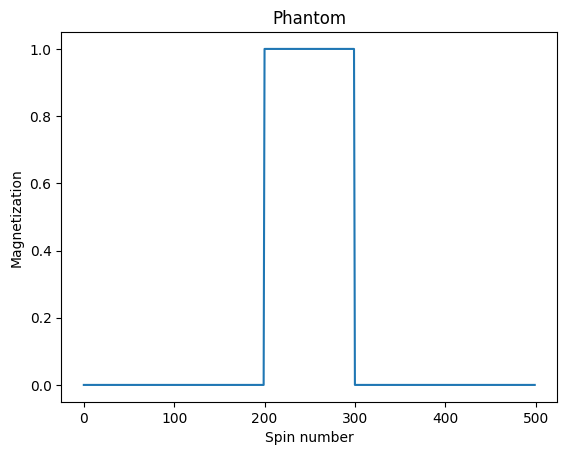

In [15]:
import numpy as np
from scipy.fft import fftshift, fft2
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr


N_spins = 500  # Number of spins in the phantom
# # Create the phantom
#The phantom is rect pulse of size 100
phantom = np.zeros(N_spins, dtype=np.complex128)  # All spins start at zero
pulse_end = 200 + 100
phantom[200:pulse_end] = 1  # Set the pulse to the desired amplitude

# phantom = np.zeros(N_spins, dtype=np.complex128)  # All spins start at zero
# phantom[250] = 1  # Set the delta function to the desired amplitude

# x = np.arange(N_spins)  # Generate an array of indices
# phantom = 2 * np.exp(1j * (2 * np.pi * 5 * x / N_spins  + 0))  # Generate a complex sine wave with the desired frequency, amplitude, and phase

# Plot the initial state of the phantom
plt.figure()
plt.plot(phantom.real)
plt.title('Phantom')
plt.xlabel('Spin number')
plt.ylabel('Magnetization')
plt.show()

gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
Gx = 0.029356505401596993*10  # Gradient strength in T/m
B0 = 1.0  # B0 field in T

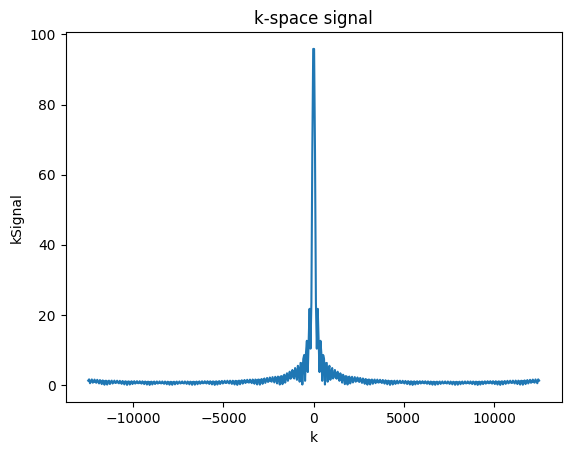

In [16]:
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)
Gx_values = time*Gx  # Gx field, non-uniform

kx_values = gamma * Gx_values  # k-space trajectory

k_signal = np.zeros_like(kx_values, dtype=np.complex128)
FOV = .2  # meters

x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)  # Assuming spins are evenly spaced


for i, kx in enumerate(kx_values):
    k_signal[i] = np.sum(phantom * np.exp(-1j  * kx * x_values))  # k-space signal is sum of all spins

# Take an fftshift of the k-space signal



# Plot the k-space signal
plt.figure()
plt.plot(kx_values, np.abs(k_signal))
plt.title('k-space signal')
plt.xlabel('k')
plt.ylabel('kSignal')
plt.show()

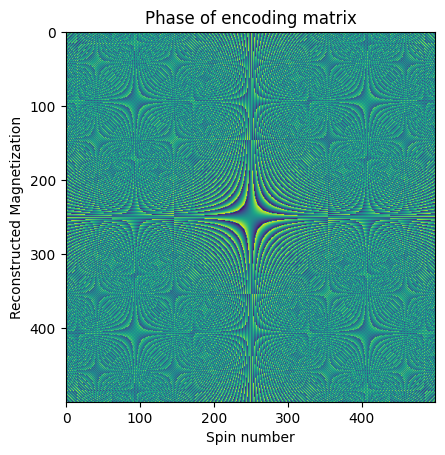

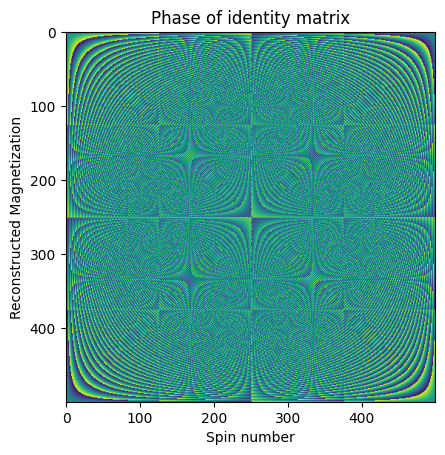

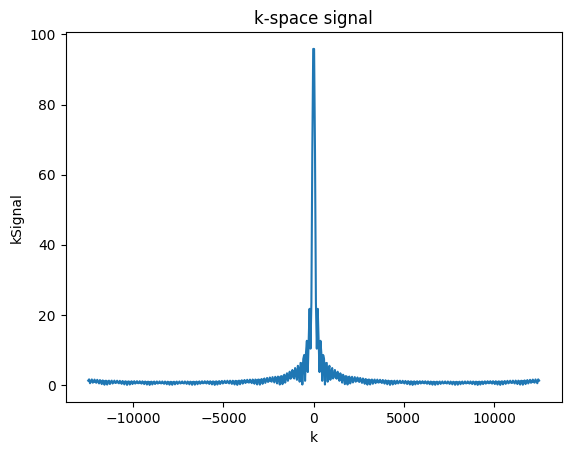

In [17]:
# Encoding matrix
E = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i in range(N_spins):
    for j in range(N_spins):
        E[i, j] = np.exp(-1j * kx_values[i] * x_values[j]) 

# Plotting the phase of the encoding matrix
plt.figure()
plt.imshow(np.angle(E))
plt.title('Phase of encoding matrix')
plt.xlabel('Spin number')
plt.ylabel('Reconstructed Magnetization')
plt.show()

# Plotting the phase of the identity matrix
plt.figure()
plt.imshow(np.angle(np.fft.ifft(np.eye(N_spins))))
plt.title('Phase of identity matrix')
plt.xlabel('Spin number')
plt.ylabel('Reconstructed Magnetization')
plt.show()

cond = np.linalg.cond(E)

# Now, let's multiply the encoding matrix E by the phantom to get the k-space signal
s = np.dot(E, phantom)


# Plot the k-space signal
plt.figure()
plt.plot(kx_values, np.abs(s))
plt.title('k-space signal')
plt.xlabel('k')
plt.ylabel('kSignal')
plt.show()


In [18]:
# E_inv = np.linalg.pinv(E)
# #Hermianize the encoding matrix by taking the transpose
# E_H = np.conj(E.T)

# # Now, let's multiply the encoding matrix E_H by the phantom to get the k-space signal
# image_2 = np.dot(E_H, s)

# # Plot the k-space signal
# plt.figure()
# plt.plot(kx, np.abs(image_2))
# plt.title('Reconstructed image with E_H')
# plt.xlabel('k')
# plt.ylabel('kSignal')
# plt.show()


# image = np.dot(E_inv, s)   # Reconstruct the image

# # Plot the reconstructed image
# plt.figure()
# plt.plot(np.abs(image))
# plt.title('Reconstructed image with pseudo inverse')
# plt.xlabel('Spin number')
# plt.ylabel('Reconstructed Magnetization')
# plt.show()

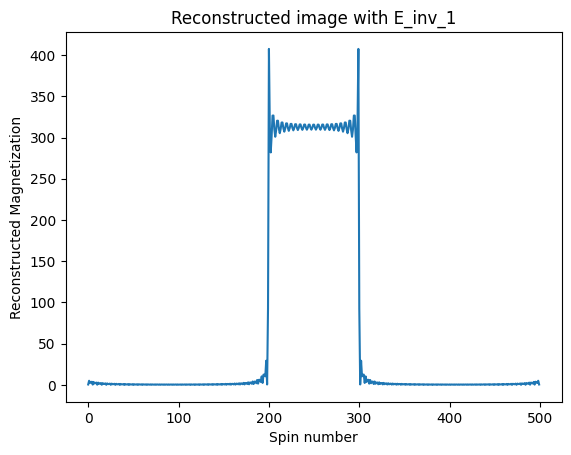

In [19]:
E_inv_1 = np.zeros((N_spins, N_spins), dtype=np.complex128)

for i in range(N_spins):
    for j in range(N_spins):
        E_inv_1[i, j] = np.exp(1j * kx_values[i] * x_values[j]) 




image_1 = np.dot(E_inv_1, s)   # Reconstruct the image


# Plot the reconstructed image
plt.figure()
plt.plot(np.abs(image_1))
plt.title('Reconstructed image with E_inv_1')
plt.xlabel('Spin number')
plt.ylabel('Reconstructed Magnetization')
plt.show()



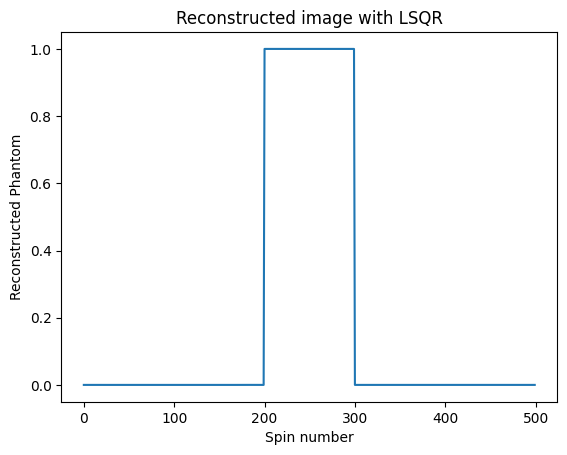

In [20]:
def find_A():
    A = np.zeros((N_spins, N_spins), dtype=np.complex128)
    for i in range(N_spins):
        for j in range(N_spins):
            A[i, j] = np.exp(-1j * kx_values[i] * x_values[j]) 
    return A




# def conjgrad(A, b, x):
#     r = b - A @ x
#     p = r
#     rsold = np.dot(r.conj(), r)

#     for i in range(len(b)):
#         Ap = A @ p
#         alpha = rsold / np.dot(p.conj(), Ap)
#         x = x + alpha * p
#         r = r - alpha * Ap
#         rsnew = np.dot(r.conj(), r)
#         if np.sqrt(rsnew) < 1e-10:
#             break
#         p = r + (rsnew / rsold) * p
#         rsold = rsnew
    
#     return x


# image_3 = conjgrad(E, s, np.zeros(N_spins, dtype=np.complex128))

A = csc_matrix(E)
x = lsqr(A, s)[0]

# Plot the reconstructed image
plt.figure()
plt.plot(x)
plt.title('Reconstructed image with LSQR')
plt.xlabel('Spin number')
plt.ylabel('Reconstructed Phantom')
plt.show()

